In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
%pylab notebook
figpath="../figures/"

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Get angular power spectrum for galaxy number counts and lensing
import camb
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb import model

lmax=2000
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both

pars.SourceTerms=model.SourceTermParams(
                           limber_windows=True,
                           limber_phi_lmin=200,
                           counts_density=True,
                           counts_redshift=True,
                           counts_lensing=True,
                           counts_velocity=True,
                           counts_radial=False,
                           counts_ISW=True,
                           counts_potential=True,
                           counts_evolve=False
                           )

# Window function power spectrum analysis

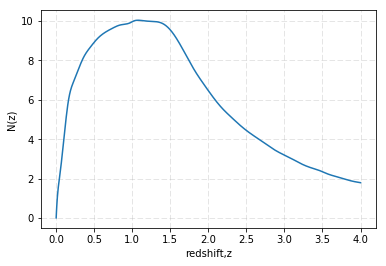

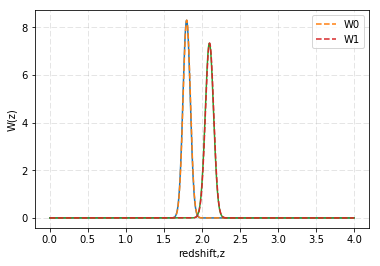

In [3]:
def return_wz(z,zc,zw):
    W=np.exp(-(z - zc) ** 2. / 2. / zw ** 2.) / np.sqrt(2. * np.pi) / zw
    return W

def return_derivative(x,y,eps=0.01):
    f=interp1d(x,y,kind="cubic",bounds_error=False,fill_value="extrapolate")
    fprime=(f(x+eps)-f(x-eps))/(2.*eps)
    return fprime

zc=arange(0.5,3,0.7)
zc=[1.8,2.1]
z=np.linspace(0.0,4.,1000) ; z_eps=mean(z[1:]-z[:-1])

data=np.loadtxt("../../continuum_ska_survey/raw_data/sim_details/nz_ska_Smin1p0uJy_alonso-f1.dat")
fn_Nz=interp1d(data[:,0],data[:,1],kind="cubic",bounds_error=False,fill_value="extrapolate")
figure()
plot(z,fn_Nz(z))
xlabel("redshift,z")
ylabel("N(z)")
grid(linestyle="dashed",alpha=0.4)
savefig(figpath + "galaxy_number_density.pdf")

Nz=fn_Nz(z)
SW=[] ; W={} ; rawW={}
for i,temp_zc in enumerate(zc):
    Wz=return_wz(z,zc=temp_zc,zw=0.03*temp_zc**0.8)
    rawW[i]=Wz
    W[i]=Wz*Nz/np.sum(Wz*Nz*z_eps)
    SW.append(SplinedSourceWindow(z=z,W=W[i],bias=1.2))
    
figure()
for i,temp_zc in enumerate(zc):
    plot(z,W[i],label="")
    plot(z,rawW[i],"--",label="W" + str(i))
    
legend(loc=0)
xlabel("redshift,z")
ylabel("W(z)")
grid(linestyle="dashed",alpha=0.4)
savefig(figpath + "window_function.pdf")

In [4]:
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = SW
results = camb.get_results(pars)
cls = results.get_source_cls_dict()
clkey=[k1 for k1 in cls.keys() if "P" not in k1]

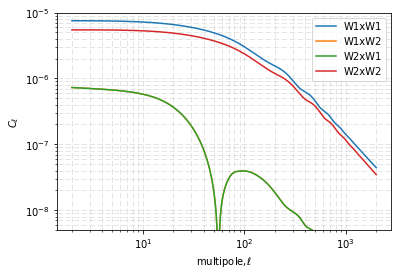

In [5]:
#Note that P is CMB lensing, as a deflection angle power (i.e. PxP is [l(l+1)]^2C_l\phi\phi/2\pi)
#lensing window functions are for kappa (and counts for the fractional angular number density)
ls=  np.arange(2, lmax+1)

plt.figure()
for spectrum in clkey:
    plt.loglog(ls, abs(cls[spectrum][2:lmax+1]*2.*pi/(ls*(ls+1))), label=spectrum)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend();
plt.xlabel("multipole,$\ell$")
# plt.ylabel(r"$\ell(\ell+1)C_{\ell}/2 \pi$")
plt.ylabel(r"$C_{\ell}$")
plt.grid(linestyle="dashed",which="both",alpha=0.4)
plt.ylim(5e-9,1e-5)
savefig(figpath + "spectra.pdf")

# Window function power spectrum analysis with derivative of window function

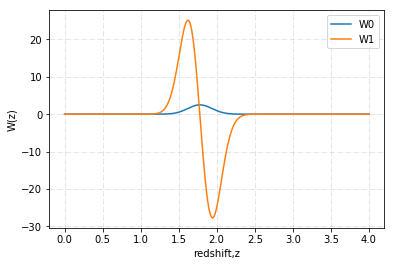

In [6]:
SW=[] ; W={} ; rawW={}
temp_zc=zc[0]
Wz=return_wz(z,zc=temp_zc,zw=0.1*temp_zc**0.8)
W[0]=Wz*Nz/np.sum(Wz*Nz*z_eps)
SW.append(SplinedSourceWindow(z=z,W=W[0]))
W[1]=return_derivative(z,W[0])*(1.+z)
SW.append(SplinedSourceWindow(z=z,W=W[1]))    
    
figure()
for i in range(2):
    plot(z,W[i],label="W" + str(i))    
legend(loc=0)
xlabel("redshift,z")
ylabel("W(z)")
grid(linestyle="dashed",alpha=0.4)
savefig(figpath + "window_function_and_derivative.pdf")

In [7]:
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = SW
results = camb.get_results(pars)
cls = results.get_source_cls_dict()
clkey=[k1 for k1 in cls.keys() if "P" not in k1]

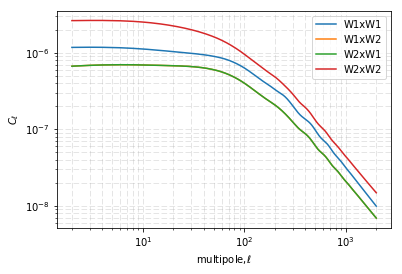

In [8]:
#Note that P is CMB lensing, as a deflection angle power (i.e. PxP is [l(l+1)]^2C_l\phi\phi/2\pi)
#lensing window functions are for kappa (and counts for the fractional angular number density)
ls=  np.arange(2, lmax+1)

plt.figure()
for spectrum in clkey:
    plt.loglog(ls, abs(cls[spectrum][2:lmax+1]*2.*pi/(ls*(ls+1))), label=spectrum)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend();
plt.xlabel("multipole,$\ell$")
# plt.ylabel(r"$\ell(\ell+1)C_{\ell}/2 \pi$")
plt.ylabel(r"$C_{\ell}$")
plt.grid(linestyle="dashed",which="both",alpha=0.4)
#plt.ylim(5e-9,1e-5)
savefig(figpath + "spectra_w_dw.pdf")

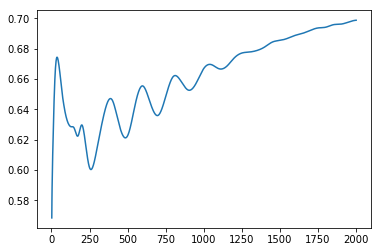

In [9]:
figure()
plot(ls[:],cls["W1xW2"][2:lmax+1]/cls["W1xW1"][2:lmax+1])

In [10]:
pars.SourceWindows

0: <SplinedSourceWindow>
  source_type = counts
  bias = 1.0
  dlog10Ndm = 0.0
1: <SplinedSourceWindow>
  source_type = counts
  bias = 1.0
  dlog10Ndm = 0.0

In [ ]:
results